In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# So we dont have to use plt.show() every time:
%matplotlib inline

In [2]:
IMAGE_SIZE = 256
IMAGE_CHANNELS = 3
EPOCS = 10
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory="dataset",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    labels='inferred',
    shuffle=True,
)

Found 6652 files belonging to 6 classes.


In [4]:
CLASS_NAMES = dataset.class_names
print("Class names:", CLASS_NAMES)
print(len(dataset)*BATCH_SIZE)

Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']
6656


Image batch shape: (32, 256, 256, 3)
Label batch as a tensor: tf.Tensor([4 5 1 4 4 0 0 4 3 4 5 5 1 5 0 4 0 5 0 1 1 4 0 0 3 3 0 5 1 1 4 5], shape=(32,), dtype=int32)
Label batch as numpy array: [4 5 1 4 4 0 0 4 3 4 5 5 1 5 0 4 0 5 0 1 1 4 0 0 3 3 0 5 1 1 4 5]
First image in batch raw tensor: tf.Tensor(
[[[199. 188. 184.]
  [196. 185. 181.]
  [197. 186. 182.]
  ...
  [189. 180. 175.]
  [195. 186. 181.]
  [199. 190. 185.]]

 [[201. 190. 186.]
  [198. 187. 183.]
  [198. 187. 183.]
  ...
  [189. 180. 175.]
  [194. 185. 180.]
  [198. 189. 184.]]

 [[201. 190. 186.]
  [198. 187. 183.]
  [197. 186. 182.]
  ...
  [196. 187. 182.]
  [199. 190. 185.]
  [200. 191. 186.]]

 ...

 [[145. 126. 119.]
  [149. 130. 123.]
  [154. 135. 128.]
  ...
  [135. 116. 109.]
  [134. 115. 108.]
  [137. 118. 111.]]

 [[148. 129. 122.]
  [149. 130. 123.]
  [153. 134. 127.]
  ...
  [147. 128. 121.]
  [143. 124. 117.]
  [139. 120. 113.]]

 [[152. 133. 126.]
  [146. 127. 120.]
  [142. 123. 116.]
  ...
  [135. 116. 109.]

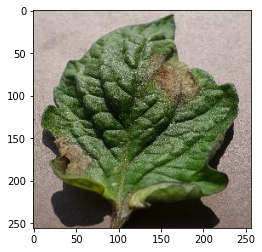

In [5]:
for image_batch, label_batch in dataset.take(1): # First batch
    print("Image batch shape:", image_batch.shape)
    print("Label batch as a tensor:", label_batch)
    print("Label batch as numpy array:", label_batch.numpy())
    print("First image in batch raw tensor:", image_batch[0])
    print("First image visualization:")
    plt.imshow(image_batch[0].numpy().astype(np.uint8))
    break

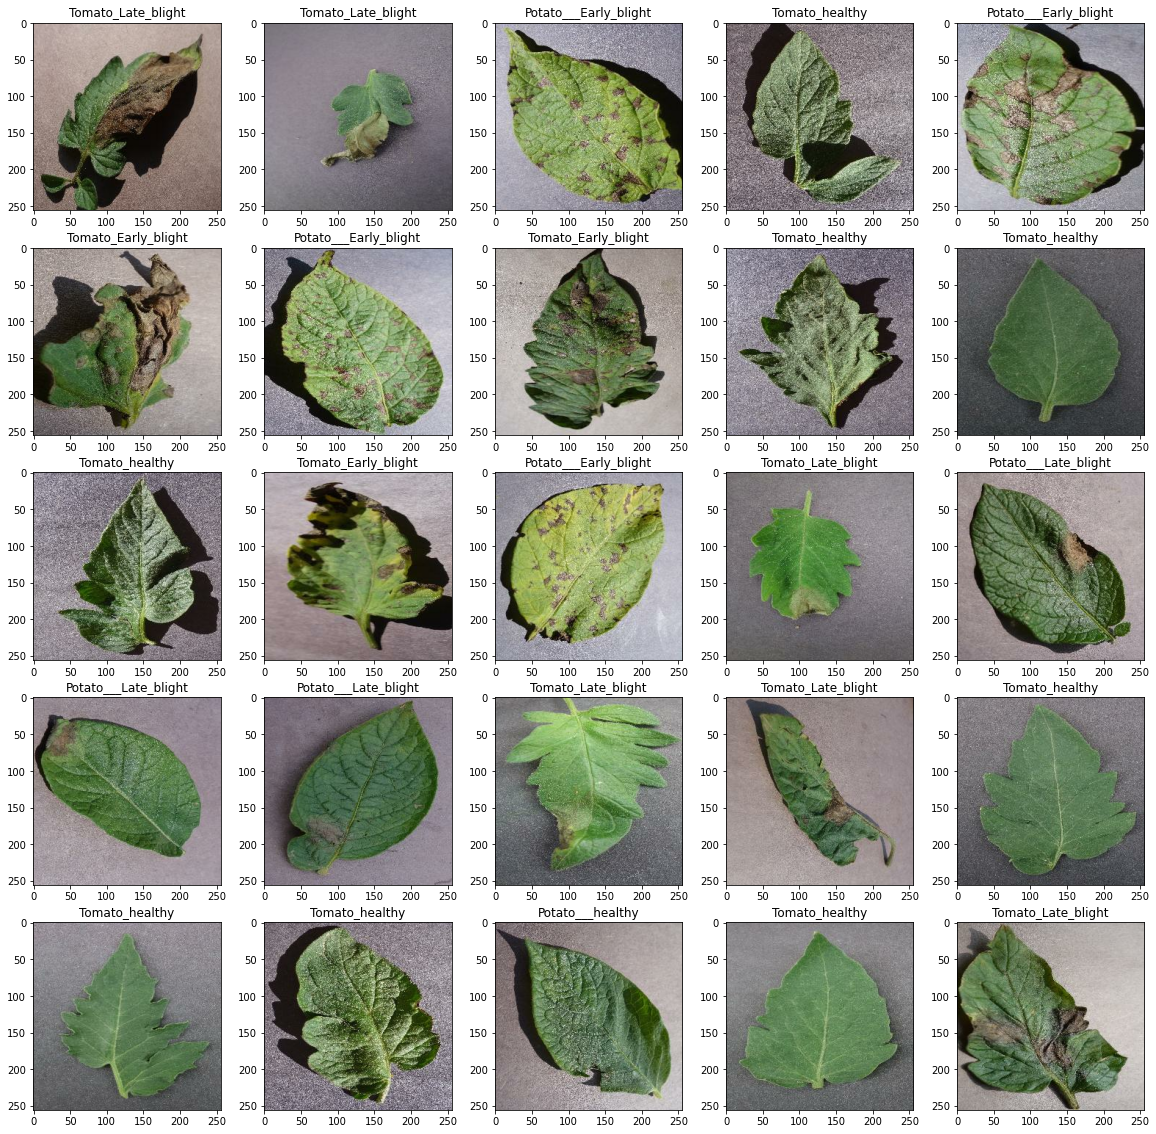

In [6]:

# plotting first 25 images in the batch
plt.figure(figsize=(20, 20))
for image_batch, label_batch in dataset.take(1):
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(image_batch[i].numpy().astype(np.uint8))
        plt.title(CLASS_NAMES[label_batch[i].numpy()])

In [7]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    """
    Returns a tuple of (train_dataset, val_dataset, test_dataset)
    """
    ds_size = len(dataset)

    # Shuffle the dataset
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=42)
    
    train_take = int(train_split * ds_size)
    val_take = int(val_split * ds_size)
    test_take = int(test_split * ds_size)

    train_dataset = dataset.take(train_take)
    val_dataset = dataset.skip(train_take).take(val_take)
    test_dataset = dataset.skip(train_take + val_take)

    return train_dataset, val_dataset, test_dataset


In [8]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [ ]:
# Make 